## EfficientNetB5 + CBAM

In [17]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.applications import EfficientNetB5
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

2025-07-01 02:25:47.355635: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751336747.569433      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751336747.633598      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [18]:
# Paths (update if different)
base_dir = '/kaggle/input/eyepacs-aptos-messidor-diabetic-retinopathy/augmented_resized_V2'  # Change if needed
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Image dimensions
IMG_SIZE = 456  # or 512 for EfficientNetB5
BATCH_SIZE = 16
NUM_CLASSES = 5

In [19]:
datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_gen = datagen.flow_from_directory(train_dir, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode='categorical')
val_gen   = datagen.flow_from_directory(val_dir, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False)
test_gen  = datagen.flow_from_directory(test_dir, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False)

Found 115241 images belonging to 5 classes.
Found 14227 images belonging to 5 classes.
Found 14201 images belonging to 5 classes.


In [20]:
from tensorflow.keras import backend as K

def cbam_block(input_feature, ratio=8):
    channel = input_feature.shape[-1]

    # ----- Channel Attention -----
    # Shared MLP
    shared_dense_one = layers.Dense(channel // ratio, activation='relu')
    shared_dense_two = layers.Dense(channel)

    # Avg Pooling
    avg_pool = layers.GlobalAveragePooling2D()(input_feature)
    avg_pool = layers.Reshape((1, 1, channel))(avg_pool)
    avg_out = shared_dense_two(shared_dense_one(avg_pool))

    # Max Pooling
    max_pool = layers.GlobalMaxPooling2D()(input_feature)
    max_pool = layers.Reshape((1, 1, channel))(max_pool)
    max_out = shared_dense_two(shared_dense_one(max_pool))

    # Combine and apply sigmoid
    channel_attention = layers.Add()([avg_out, max_out])
    channel_attention = layers.Activation('sigmoid')(channel_attention)
    channel_refined = layers.Multiply()([input_feature, channel_attention])

    # ----- Spatial Attention -----
    # Compute avg and max spatially
    avg_pool = layers.Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(channel_refined)
    max_pool = layers.Lambda(lambda x: K.max(x, axis=3, keepdims=True))(channel_refined)
    concat = layers.Concatenate(axis=3)([avg_pool, max_pool])

    spatial_attention = layers.Conv2D(1, kernel_size=7, padding='same', activation='sigmoid')(concat)
    refined_feature = layers.Multiply()([channel_refined, spatial_attention])

    return refined_feature

In [21]:
inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = EfficientNetB5(include_top=False, weights='imagenet', input_tensor=inputs)(inputs)
x = cbam_block(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.25)(x)
outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)

model = models.Model(inputs, outputs)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

I0000 00:00:1751336926.402629      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1751336926.403275      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


115263384/115263384 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [22]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 456, 456, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ efficientnetb5            │ (None, 15, 15, 2048)   │     28,513,527 │ input_layer[0][0]      │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 2048)           │              0 │ efficientnetb5[0][0]   │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling2d      │ (None, 2048)           │              0 │ efficientnetb5[0][0]   │
│ (GlobalMaxPooling2D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 1, 1, 2048)     │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_1 (Reshape)       │ (None, 1, 1, 2048)     │              0 │ global_max_pooling2d[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 1, 1, 256)      │        524,544 │ reshape[0][0],         │
│                           │                        │                │ reshape_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 1, 1, 2048)     │        526,336 │ dense[0][0],           │
│                           │                        │                │ dense[1][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 1, 1, 2048)     │              0 │ dense_1[0][0],         │
│                           │                        │                │ dense_1[1][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 1, 1, 2048)     │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply (Multiply)       │ (None, 15, 15, 2048)   │              0 │ efficientnetb5[0][0],  │
│                           │                        │                │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)           │ (None, 15, 15, 1)      │              0 │ multiply[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_1 (Lambda)         │ (None, 15, 15, 1)      │              0 │ multiply[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 15, 15, 2)      │              0 │ lambda[0][0],          │
│                           │                        │                │ lambda_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 15, 15, 1)      │             99 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply_1 (Multiply)

 Total params: 30,099,551 (114.82 MB)

 Trainable params: 29,922,200 (114.14 MB)

 Non-trainable params: 177,351 (692.78 KB)

In [23]:
checkpoint_cb = callbacks.ModelCheckpoint('/kaggle/working/best_efficientnetb5_cbam.h5', save_best_only=True, monitor='val_loss')
earlystop_cb = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr_cb = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=5,
    callbacks=[checkpoint_cb, earlystop_cb, reduce_lr_cb]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 456, 456, 3))
  warnings.warn(msg)
I0000 00:00:1751337065.030711      81 service.cc:148] XLA service 0x7e29f0003ec0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751337065.031770      81 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1751337065.031802      81 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1751337077.759776      81 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1751337090.610952      81 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1751337090.813978      81 gpu_timer.cc:82] Delay kernel

2534/7203 ━━━━━━━━━━━━━━━━━━━━ 1:26:53 1s/step - accuracy: 0.5133 - loss: 1.4508

E0000 00:00:1751340010.649421      81 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1751340010.823632      81 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1751340021.412428      81 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1751340021.579585      81 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1751340022.119381      81 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

7203/7203 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6039 - loss: 1.1570

E0000 00:00:1751345581.028781      81 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1751345581.178096      81 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


7203/7203 ━━━━━━━━━━━━━━━━━━━━ 8658s 1s/step - accuracy: 0.6039 - loss: 1.1569 - val_accuracy: 0.7974 - val_loss: 0.5995 - learning_rate: 1.0000e-04
Epoch 2/5
7203/7203 ━━━━━━━━━━━━━━━━━━━━ 8339s 1s/step - accuracy: 0.7828 - loss: 0.6106 - val_accuracy: 0.8068 - val_loss: 0.5753 - learning_rate: 1.0000e-04
Epoch 3/5
7203/7203 ━━━━━━━━━━━━━━━━━━━━ 8333s 1s/step - accuracy: 0.8434 - loss: 0.4461 - val_accuracy: 0.8111 - val_loss: 0.6027 - learning_rate: 1.0000e-04
Epoch 4/5
7203/7203 ━━━━━━━━━━━━━━━━━━━━ 8333s 1s/step - accuracy: 0.8924 - loss: 0.3125 - val_accuracy: 0.7961 - val_loss: 0.6648 - learning_rate: 1.0000e-04
Epoch 5/5
7203/7203 ━━━━━━━━━━━━━━━━━━━━ 8322s 1s/step - accuracy: 0.9473 - loss: 0.1607 - val_accuracy: 0.8155 - val_loss: 0.7432 - learning_rate: 2.0000e-05


In [24]:
import pickle

# Save history to disk
with open("E5_training_history.pkl", "wb") as f:
    pickle.dump(history.history, f)

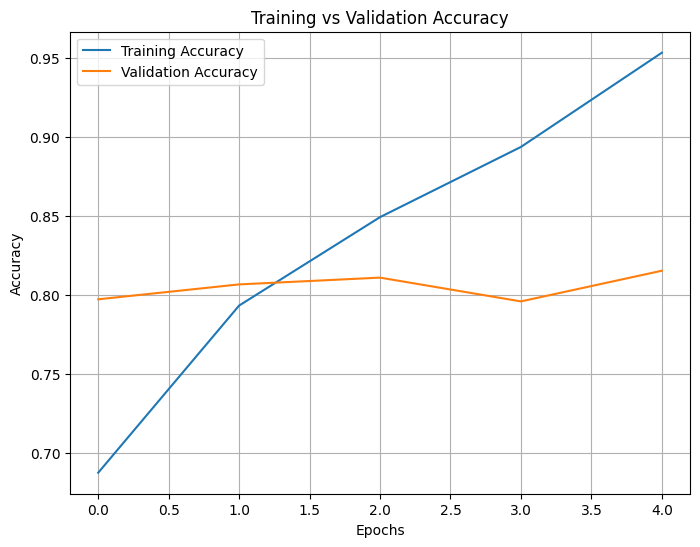

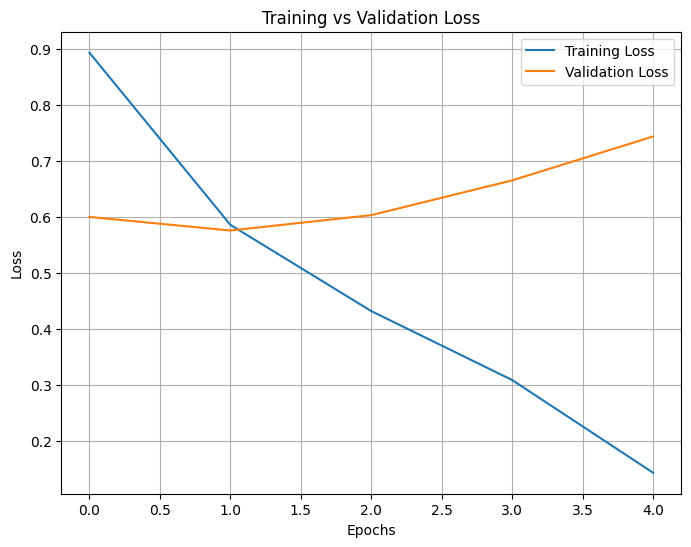

In [25]:
history_data = history.history

import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(8, 6))
plt.plot(history_data['accuracy'], label='Training Accuracy')
plt.plot(history_data['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot loss
plt.figure(figsize=(8, 6))
plt.plot(history_data['loss'], label='Training Loss')
plt.plot(history_data['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(16, 456, 456, 3))
  warnings.warn(msg)


888/888 ━━━━━━━━━━━━━━━━━━━━ 290s 309ms/step
              precision    recall  f1-score   support

           0     0.8694    0.9387    0.9027      6896
           1     0.4925    0.4055    0.4448      1862
           2     0.5186    0.3765    0.4362      2999
           3     0.4079    0.5930    0.4833       978
           4     0.6780    0.7510    0.7126      1466

    accuracy                         0.7069     14201
   macro avg     0.5933    0.6129    0.5959     14201
weighted avg     0.6944    0.7069    0.6957     14201



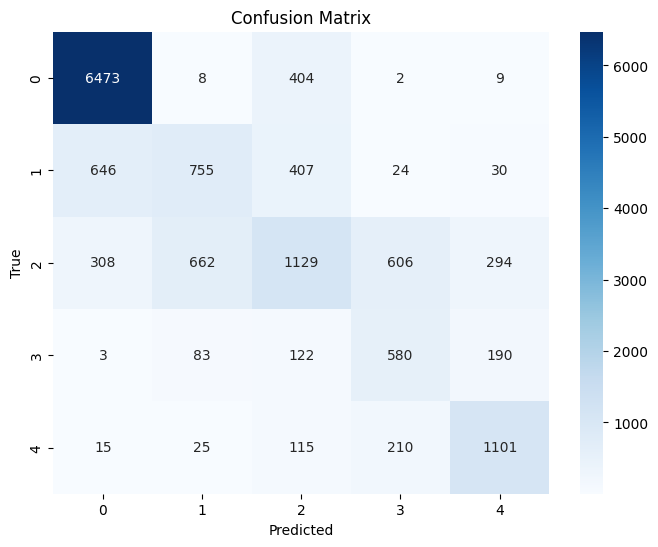

Quadratic Weighted Kappa (QWK): 0.8451


In [26]:
y_true = test_gen.classes
y_pred_probs = model.predict(test_gen)
y_pred = np.argmax(y_pred_probs, axis=1)

# Classification report
print(classification_report(y_true, y_pred, digits=4))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# QWK
qwk = cohen_kappa_score(y_true, y_pred, weights='quadratic')
print(f"Quadratic Weighted Kappa (QWK): {qwk:.4f}")
